In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset_dir = Path("data/huge_stock_market_dataset/")
results_dir = Path("results")

In [3]:
ts_info = pd.read_csv(dataset_dir / "selected.csv")
ts_info["ts_id"] = ts_info.index
results = []
for results_type in ("pure", "QuantGAN_synth", "FourierFlow_synth", "RealNVP_synth", "TTS_GAN_synth"):
    for model in ("LSTM", "TCN", "cbr"):
        df = pd.read_csv(results_dir / f"{results_type}_{model}.csv")
        df["model"] = model
        df["results_type"] = results_type
        results.append(df)
results = pd.concat(results)
results["model"].replace("cbr", "CatBoostRegressor", inplace=True)
results["results_type"].replace(["pure", "QuantGAN_synth", "FourierFlow_synth", "RealNVP_synth", "TTS_GAN_synth"],
                                ["train set", "QuantGAN synthetic data", "FourierFlow synthetic data", "RealNVP synthetic data", "TTS GAN synthetic data"], 
                                inplace=True)
results

,train,val,model,results_type
0,0.095871,0.091669,LSTM,train set
1,0.038049,0.052777,LSTM,train set
2,0.007282,0.005239,LSTM,train set
3,0.009842,0.010587,LSTM,train set
4,0.016299,0.012812,LSTM,train set
...,...,...,...,...
19,0.009250,0.005596,CatBoostRegressor,TTS GAN synthetic data
20,3874.674253,3874.674607,CatBoostRegressor,TTS GAN synthetic data
21,0.008822,0.007025,CatBoostRegressor,TTS GAN synthetic data
22,0.024266,0.029026,CatBoostRegressor,TTS GAN synthetic data


In [4]:
results_agg = results.groupby(by=["model", "results_type"], axis=0).agg(train=("train", "mean"), val=("val", "mean"))
results_agg

train         val
model             results_type                                      
CatBoostRegressor FourierFlow synthetic data    0.023682    0.020897
                  QuantGAN synthetic data       0.025169    0.020839
                  RealNVP synthetic data        0.022648    0.020972
                  TTS GAN synthetic data      161.471475  161.468091
                  train set                     0.023467    0.020813
LSTM              FourierFlow synthetic data    0.022806    0.022078
                  QuantGAN synthetic data       0.025344    0.020695
                  RealNVP synthetic data        0.020826    0.021979
                  TTS GAN synthetic data        0.753722    0.743008
                  train set                     0.023882    0.020938
TCN               FourierFlow synthetic data    0.021676    0.021634
                  QuantGAN synthetic data       0.025414    0.020757
                  RealNVP synthetic data        0.020013    0.021960
                  TTS GAN synthetic data        0.055142    0.051338
                  train set                     0.022132    0.021120

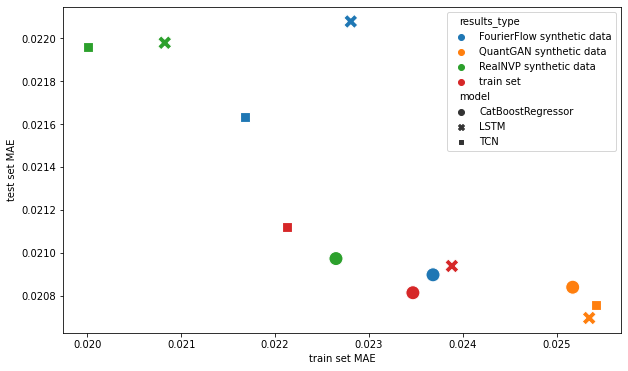

In [7]:
fig, ax = plt.subplots(1, figsize=(10, 6))
sns.scatterplot(data=results_agg[results_agg.index.get_level_values(1) != "TTS GAN synthetic data"], x="train", y="val", hue="results_type", style="model", s=200, ax=ax)
ax.set_xlabel("train set MAE")
ax.set_ylabel("test set MAE")
plt.show()

<AxesSubplot:xlabel='model', ylabel='val'>

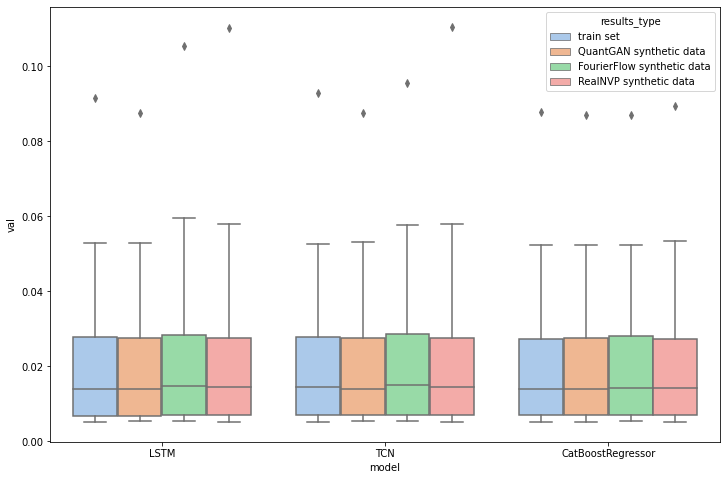

In [9]:
fig, ax = plt.subplots(1, figsize=(12, 8))
sns.boxplot(data=results[results.results_type != "TTS GAN synthetic data"], x="model", y="val", hue="results_type", palette="pastel", ax=ax)

# Gains

In [10]:
pure = results[results.results_type == "train set"]
gains = None
for synth_rt in (x for x in results.results_type.unique() if x != "train set"):
    synth_df = results[results.results_type == synth_rt]
    gain = (pure.groupby([pure.index, "model"]).mean() - synth_df.groupby([synth_df.index, "model"]).mean()) / pure.groupby([pure.index, "model"]).mean() * 100
    gain.index, gain["model"] = gain.index.get_level_values(0), gain.index.get_level_values(1)
    synth_rt = synth_rt.split(' ')[0]
    gain.rename(columns={"train": f"train_{synth_rt}", "val": f"val_{synth_rt}"}, inplace=True)
    gain["ts_id"] = gain.index
    if gains is None:
        gains = gain
    else:
        gains = gains.merge(gain, on=["model", "ts_id"])

gains = gains.merge(ts_info, on="ts_id")
gains

,train_QuantGAN,val_QuantGAN,model,ts_id,train_FourierFlow,val_FourierFlow,train_RealNVP,val_RealNVP,train_TTS,val_TTS,filename,length,uptrending_rate
0,-14.984101,1.092810,CatBoostRegressor,0,0.009923,1.075458,8.902737,-1.783872,-33.664422,-34.074753,opgnw.us.txt,444,0.388262
1,-12.248072,4.345460,LSTM,0,44.364159,-14.995131,78.998564,-20.307157,-26.631186,-24.995217,opgnw.us.txt,444,0.388262
2,-41.752634,5.733166,TCN,0,43.435590,-2.795060,70.139684,-18.988814,-62.445382,-25.467910,opgnw.us.txt,444,0.388262
3,-7.121055,-0.412516,CatBoostRegressor,1,1.888017,-0.154011,4.250660,-2.036028,-7.440423,2.007823,dare.us.txt,905,0.431416
4,-5.089717,-0.094556,LSTM,1,0.437285,-12.952974,8.553213,-9.833632,-5.514545,3.155496,dare.us.txt,905,0.431416
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-0.722312,0.048177,LSTM,22,-0.620685,-0.167292,-0.198201,0.309734,-4.798556,-2.126875,gfi.us.txt,6686,0.454899
68,-8.620905,1.549468,TCN,22,-7.438851,1.511683,-6.349097,2.275034,-12.136802,-0.091893,gfi.us.txt,6686,0.454899
69,-5.009985,-0.304437,CatBoostRegressor,23,3.046810,0.333041,3.693611,0.068648,-5.102041,-0.056355,hig.us.txt,5514,0.506258
70,-9.876057,1.136465,LSTM,23,-9.663885,-0.102063,-8.688046,1.411714,-10.757791,2.524569,hig.us.txt,5514,0.506258


In [11]:
gains.groupby(["model"]).mean().drop(columns=["ts_id", "length", "uptrending_rate"])

,train_QuantGAN,val_QuantGAN,train_FourierFlow,val_FourierFlow,train_RealNVP,val_RealNVP,train_TTS,val_TTS
model,,,,,,,,
CatBoostRegressor,-6.744821,-0.484926,-1.865237,-0.772547,2.976504,-0.424581,-1.082588e+06,-2.226441e+06
LSTM,-4.636783,-0.137742,-1.264897,-3.044220,3.081292,-1.442988,-4.935446e+03,-9.952338e+03
TCN,-9.952288,0.303305,-2.759000,-1.897040,2.482338,-0.783130,-2.064790e+02,-3.977413e+02


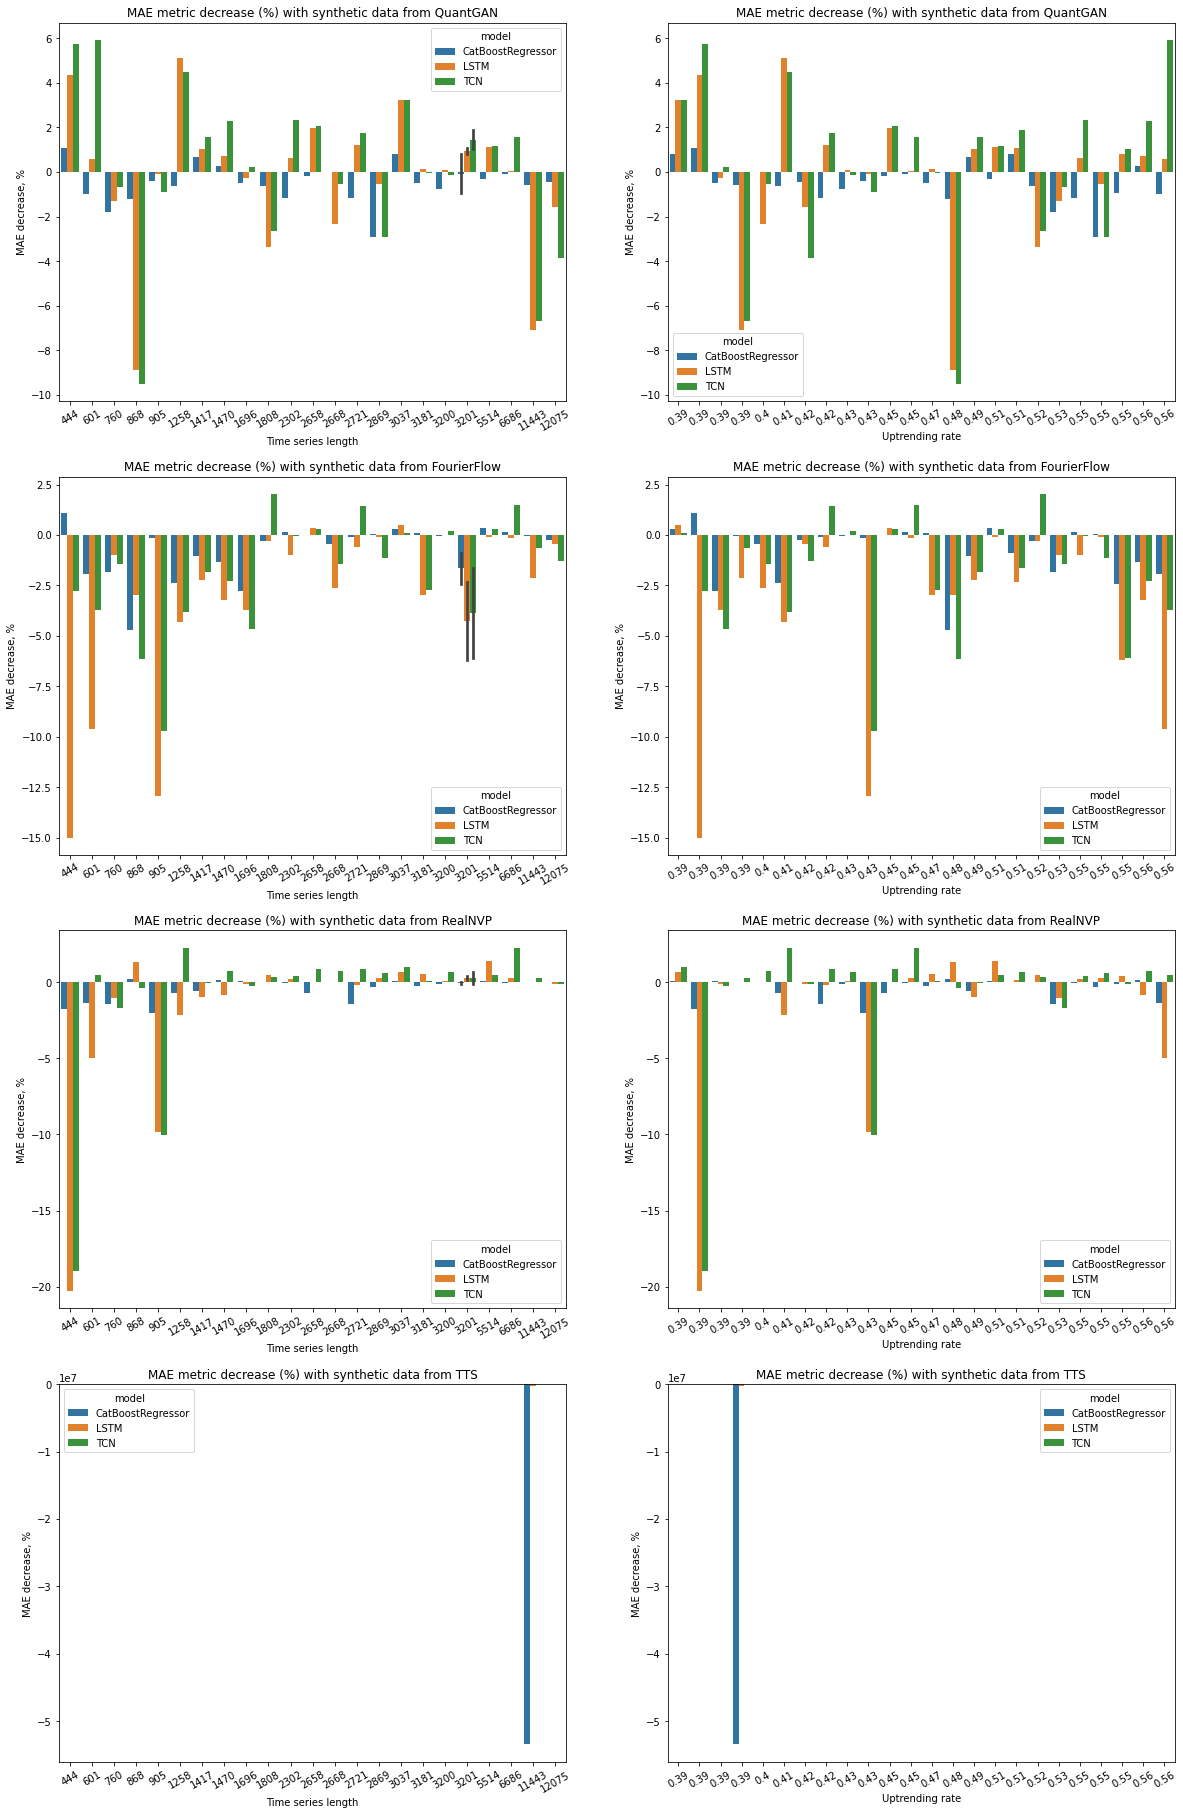

In [14]:
synth_models = ["QuantGAN", "FourierFlow", "RealNVP", "TTS"]
fig, axs = plt.subplots(len(synth_models), 2, figsize=(20, 8 * len(synth_models)))

for i in range(len(synth_models)):
    sns.barplot(data=gains, x="length", y=f"val_{synth_models[i]}", hue="model", ax=axs[i][0])
    axs[i][0].set_xlabel("Time series length")
    axs[i][0].set_xticklabels(sorted(gains["length"].unique()), rotation=30)
    axs[i][0].set_ylabel("MAE decrease, %")

    sns.barplot(data=gains, x="uptrending_rate", y=f"val_{synth_models[i]}", hue="model", ax=axs[i][1])
    axs[i][1].set_xlabel("Uptrending rate")
    axs[i][1].set_xticklabels(map(lambda x: round(x, 2), sorted(gains.uptrending_rate.unique())), rotation=30)
    axs[i][1].set_ylabel("MAE decrease, %")

    for j in range(2): axs[i][j].set_title(f"MAE metric decrease (%) with synthetic data from {synth_models[i]}")
    
plt.show()